In [1]:
%load_ext autoreload
%autoreload 2

Note: requires contents in `output_lake8x8/`, which is produced by running this script -> 

In [2]:
import numpy as np
import pandas as pd
import pickle, itertools

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import collections  as mc

In [4]:
import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif'

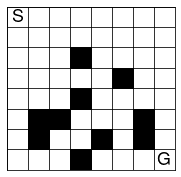

In [5]:
fig, ax = plt.subplots(figsize=(3,3))
plt.xlim(0,8)
plt.ylim(0,8)
plt.grid(c='k')
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(length=0)
plt.text(0.5, 7.5, 'S', fontsize=18, ha='center', va='center')
plt.text(7.5, 0.5, 'G', fontsize=18, ha='center', va='center')

for hole in [
    (1,1), (1,2),
    (2,2),
    (3,0), (3,3), (3,5),
    (4,1), (5,4), (6,1), (6,2),
]:
    rect = patches.Rectangle(hole,1,1,linewidth=1,edgecolor='k',facecolor='k')
    ax.add_patch(rect)

plt.savefig('figures/lake8x8.pdf')
plt.show()

## Load environment

In [6]:
zeta_range = [0.0, 0.01, 0.02, 0.03]

In [7]:
from lib import envs, algos, helpers
from lib.envs import FrozenLakeEnv_slip_rand_reward
from lib.envs import LEFT, RIGHT, UP, DOWN
from lib.helpers import np_exclude

In [8]:
np.random.seed(42)
env = FrozenLakeEnv_slip_rand_reward(
    map_name="8x8", 
    slip_prob=0.0,
    reward_modifier = [0.000, 0.001, 0.002, 0.003],
)
nS, nA = env.nS, env.nA
S_terminal = env.S_terminal

In [9]:
gamma = 0.9
tol = 1e-10

In [ ]:
with open('output_lake8x8/frozenlake_8x8_rrew.Q.pkl', 'rb') as f:
    tmp = pickle.load(f)
    Q_star = tmp['Qs'][-1] # Q table after the final update
    V_star = Q_star.max(axis=1)

## Save learned policies

In [ ]:
Qs_by_zeta = {}
for zeta in zeta_range:
    metadata = pickle.load(open('output_lake8x8/frozenlake_8x8_rrew.greedy.zeta={}.pkl'.format(zeta), 'rb'))
    Q = metadata['Qs'][-1]
    Qs_by_zeta[zeta] = Q

In [ ]:
import joblib

In [ ]:
pi_by_zeta = {}
for zeta in [0.0, 0.01, 0.02, 0.03]:
    Q = Qs_by_zeta[zeta]
    pi = (Q >= (1-zeta-tol) * Q_star.max(axis=1, keepdims=True)).astype(int)
    pi_by_zeta[zeta] = pi

In [ ]:
joblib.dump(pi_by_zeta, 'lake8x8_pi_by_zeta.joblib')
joblib.dump(Qs_by_zeta, 'lake8x8_Qs_by_zeta.joblib')

## Plot learned policies

In [11]:
import joblib

In [ ]:
with open('saved_memory/frozenlake_8x8_rrew.Q.pkl', 'rb') as f:
    tmp = pickle.load(f)
    Q_star = tmp['Qs'][-1] # Q table after the final update
    V_star = Q_star.max(axis=1)

In [13]:
pi_by_zeta = joblib.load('lake8x8_pi_by_zeta.joblib')
Qs_by_zeta = joblib.load('lake8x8_Qs_by_zeta.joblib')

In [11]:
def calculate_Q_V(Q, Q_star):
    # always choose the worst among the top near-equivalent actions
    Q_cutoff = (1-zeta-tol) * Q_star.max(axis=1, keepdims=True)
    pi = np.zeros_like(Q)
    pi[Q >= Q_cutoff] = 1
    a_star_hat = np.ma.masked_array(Q, 1-pi).min(axis=1, keepdims=True).data
    pi[Q != a_star_hat] = 0
    pi = pi / pi.sum(axis=1, keepdims=True)
    V = (Q * pi).sum(axis=1)
    return Q, V

In [12]:
def visualize_policy(policy, ncol=1, terminal=[]):
    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3

    _actions = ['L', 'D', 'R', 'U']
    _actions = ['←', '↓', '→', '↑']
    _actions = ['<', 'V', '>', 'A']

    for i, pi_a_s in enumerate(policy):
        if i in terminal:
            print('{:^6}'.format(''), end='|')
        else:
            idxs = np.where(pi_a_s > 0)[0]
            actions_str = ''.join(_actions[idx] for idx in idxs)
            print('{:^6}'.format(actions_str), end='|')
        if (i+1) % ncol == 0:
            print('\n', end='')

In [13]:
Q_pi_ALL = {}
for zeta in zeta_range:
    print('='*30)
    print('zeta:', zeta)
    Q = Qs_by_zeta[zeta]
    Q_pi, V_pi = calculate_Q_V(Q, Q_star)
    pi = (Q >= (1-zeta-tol) * Q_star.max(axis=1, keepdims=True)).astype(int)
    psize = np_exclude(pi, env.S_terminal).sum(axis=1).mean()
    print('Avg. policy size :', psize) # for non-terminal states
    
    pi = algos.zeta_optimal_worst_case_policy(Q, dict(Q_star=Q_star, zeta=zeta))
    V_pi = algos.policy_eval(env, pi, gamma=gamma)
    print(
        'Policy suboptimality (policy eval):', 
        (1 - np_exclude(V_pi, S_terminal) / np_exclude(V_star, S_terminal)).max()
    )
    visualize_policy(algos.zeta_optimal_stochastic_policy(Q, dict(Q_star=Q_star, zeta=zeta)), 8, S_terminal)

zeta: 0.0
Avg. policy size : 1.0
Policy suboptimality (policy eval): 0.0
  V   |  V   |  V   |  >   |  V   |  >   |  V   |  V   |
  V   |  >   |  >   |  >   |  V   |  V   |  >   |  V   |
  >   |  >   |  V   |      |  V   |  >   |  V   |  V   |
  >   |  >   |  >   |  >   |  V   |      |  >   |  V   |
  >   |  >   |  A   |      |  V   |  V   |  >   |  V   |
  A   |      |      |  >   |  >   |  V   |      |  V   |
  V   |      |  >   |  A   |      |  V   |      |  V   |
  >   |  >   |  A   |      |  >   |  >   |  >   |      |
zeta: 0.01
Avg. policy size : 1.2452830188679245
Policy suboptimality (policy eval): 0.009258404059737213
  V   |  V   |  V>  |  >   |  V   |  V>  |  V>  |  V   |
  V   |  V>  |  >   |  >   |  V   |  V>  |  V>  |  V   |
  >   |  >   |  V   |      |  V   |  >   |  V>  |  V   |
  >   |  >   |  >   |  >   |  V   |      |  V>  |  V   |
  >A  |  >A  |  A   |      |  V>  |  V>  |  >   |  V   |
  VA  |      |      |  >   |  >   |  V   |      |  V   |
  V   |      |  >   |  

## Plot routes

- run the following blocks of code for `zeta` $\in \{0.00, 0.01, 0.02, 0.03\}$
- the error message produced by `plt.show()` can be ignored, and the correct figures are saved as pdf files. 

In [12]:
import joblib

In [17]:
with open('saved_memory/frozenlake_8x8_rrew.Q.pkl', 'rb') as f:
    tmp = pickle.load(f)
    Q_star = tmp['Qs'][-1] # Q table after the final update
    V_star = Q_star.max(axis=1)

In [13]:
pi_by_zeta = joblib.load('lake8x8_pi_by_zeta.joblib')
Qs_by_zeta = joblib.load('lake8x8_Qs_by_zeta.joblib')

In [36]:
zeta = 0.0
pi = pi_by_zeta[zeta]
Q = Qs_by_zeta[zeta]

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
plt.xlim(0,8)
plt.ylim(0,8)
plt.grid(c='k')
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.yticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(length=0)
plt.text(0.5, 7.5, 'S', fontsize=18, ha='center', va='center', alpha=0.25)
plt.text(7.5, 0.5, 'G', fontsize=18, ha='center', va='center', alpha=0.25)

for hole in [
    (1,1), (1,2),
    (2,2),
    (3,0), (3,3), (3,5),
    (4,1), (5,4), (6,1), (6,2),
]:
    rect = patches.Rectangle(hole,1,1,linewidth=1,edgecolor='k',facecolor='k')
    ax.add_patch(rect)

offset = 0.5
style="Simple,tail_width=0.1,head_width=2,head_length=2"
kw = dict(arrowstyle=style, color="k")
for s in range(env.nS):
    if s in env.S_terminal:
        continue
    row, col = s//8, s%8
    x, y = col, 8-row
    for action in np.argwhere(pi[s] == 1).flatten():
        if action == LEFT:
            a = patches.FancyArrowPatch((x+0.5,y-0.5), (x+0.5-0.5,y-0.5),connectionstyle="arc3,rad=0", **kw)
        elif action == RIGHT:
            a = patches.FancyArrowPatch((x+0.5,y-0.5), (x+0.5+0.5,y-0.5),connectionstyle="arc3,rad=0", **kw)
        elif action == UP:
            a = patches.FancyArrowPatch((x+0.5,y-0.5), (x+0.5,y-0.5+0.5),connectionstyle="arc3,rad=0", **kw)
        elif action == DOWN:
            a = patches.FancyArrowPatch((x+0.5,y-0.5), (x+0.5,y-0.5-0.5),connectionstyle="arc3,rad=0", **kw)
            
        plt.gca().add_patch(a)


lines = [[(0.5, 7.5), (0.5, 5.5)], [(0.5, 5.5), (2.5, 5.5)], [(2.5, 5.5), (2.5, 4.5)],
         [(2.5, 4.5), (4.5, 4.5)], [(4.5, 4.5), (4.5, 2.5)], [(4.5, 2.5), (5.5, 2.5)], 
         [(5.5, 2.5), (5.5, 0.5)], [(5.5, 0.5), (7.5, 0.5)], ]
lc = mc.LineCollection(lines, colors='r', linewidths=4, zorder=1, alpha=0.5)
ax.add_collection(lc)

if zeta >= 0.01:
    offset = 0.1
    lines = [[(0.5+offset, 7.5), (0.5+offset, 5.5+offset)], [(0.5+offset, 5.5+offset), (2.5+offset, 5.5+offset)], [(2.5+offset, 5.5+offset), (2.5+offset, 4.5+offset)],
             [(2.5+offset, 4.5+offset), (4.5+offset, 4.5+offset)], [(4.5+offset, 4.5+offset), (4.5+offset, 3.5)], [(4.5+offset, 3.5), (7.5, 3.5)], 
             [(7.5, 3.5), (7.5, 0.5)], 
             [(5.5, 3.5), (5.5, 2.5)], 
            ]
    lc = mc.LineCollection(lines, colors='orange', linewidths=4, zorder=1, alpha=0.5)
    ax.add_collection(lc)

if zeta >= 0.02:
    offset = 0.1
    lines = [[(0.5-offset, 7.5), (0.5-offset, 4.5+offset)], [(0.5-offset, 4.5), (2.5+offset, 4.5)], [(1.5+offset, 5.5), (1.5+offset, 4.5)],
            ]
    lc = mc.LineCollection(lines, colors='tab:red', linewidths=4, zorder=1, alpha=0.5)
    ax.add_collection(lc)

if zeta >= 0.03:
    offset = 0.1
    lines = [[(0.5, 7.5), (1.5, 7.5)], [(1.5, 7.5), (1.5, 6.5)], [(0.5, 6.5), (1.5, 6.5)]] \
    + [
        [(1.5+i, 6.5), (2.5+i, 6.5)] for i in range(6)
    ] + [
        [(1.5, 6.5), (1.5, 5.5)], [(2.5, 6.5), (2.5, 5.5)], 
        [(4.5, 6.5), (4.5, 4.5)], [(5.5, 6.5), (5.5, 5.5)], [(6.5, 6.5), (6.5, 3.5)], 
    ] + [
        [(4.5+i, 5.5), (5.5+i, 5.5)] for i in range(3)
    ] + [
        [(7.5, 6.5-j), (7.5, 5.5-j)] for j in range(3)
    ] + [
        [(6.5, 4.5), (7.5, 4.5)]
    ]
    lc = mc.LineCollection(lines, colors='tab:blue', linewidths=4, zorder=1, alpha=0.5)
    ax.add_collection(lc)

# if zeta >= 0.04:
#     lines = [[(1.5+i, 7.5), (2.5+i, 7.5)] for i in range(6)] \
#     + [[(2.5+i, 7.5), (2.5+i, 6.5)] for i in range(6)]
#     lc = mc.LineCollection(lines, colors='tab:green', linewidths=4, zorder=1, alpha=0.5)
#     ax.add_collection(lc)

psize = np_exclude(pi, env.S_terminal).sum(axis=1).mean()
plt.text(4, -0.3, '$\zeta={:.2f}$\t Avg. policy size: {:.2f}'.format(zeta, psize), 
         fontsize=12, fontname='Helvetica', ha='center', va='top')

pi_worst = algos.zeta_optimal_worst_case_policy(Q, dict(Q_star=Q_star, zeta=zeta))
V_pi_worst = algos.policy_eval(env, pi_worst, gamma=gamma)
plt.text(4, -1.0, 'worst-case near-optimality: {:.1%}'.format(
    (np_exclude(V_pi_worst, S_terminal) / np_exclude(V_star, S_terminal)).min()
), fontsize=12, fontname='Helvetica', ha='center', va='top')

plt.savefig('figures/lake8x8.zeta={}.pdf'.format(zeta), bbox_inches='tight')
# plt.show()